In [52]:
import itertools

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tokenizer

df = pd.read_csv("data.csv", dtype="str")

FIELDS = [
    'first_name',
    'last_name',
    'city',
    #'date_of_birth',
    #'gender',
    'state',
]

NUMBER_FIELDS = [
    'social_security_number',
    'phone_number',
]

ALL_FIELDS = FIELDS + NUMBER_FIELDS

L = 1000
kn = 150
eps = 3

df["id"] = [row.rec_id.split("-")[1] for row in df.itertuples()]

for field in FIELDS:
    print(field)
    df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_name(L, kn, eps, str(name), prefix=f"{field}:"))
    
for field in NUMBER_FIELDS:
    print(field)
    df[f"token_{field}"] = df[field].apply(lambda name: tokenizer.tokenize_number(L, kn, eps, str(name), prefix=f"{field}:"))

df["joined_bf"] = [np.array(list(itertools.chain(*[getattr(row, f"token_{field}") for field in FIELDS + NUMBER_FIELDS]))) for row in df.itertuples()]


first_name
last_name
city
state
social_security_number
phone_number


In [8]:
dices = pd.DataFrame.from_records(
    [
        dict(
            [
                ("id1", a.rec_id),
                ("id2", b.rec_id),
                ("dice", tokenizer.dice(a.joined_bf, b.joined_bf)),
                ("same", a.id == b.id),
            ]
            + [
                (
                    f"dice_{field}",
                    tokenizer.dice(getattr(a, f"token_{field}"), getattr(b, f"token_{field}")),
                )
                for field in ALL_FIELDS
            ]
        )
        for a, b in itertools.combinations(df.itertuples(), 2)
    ]
)

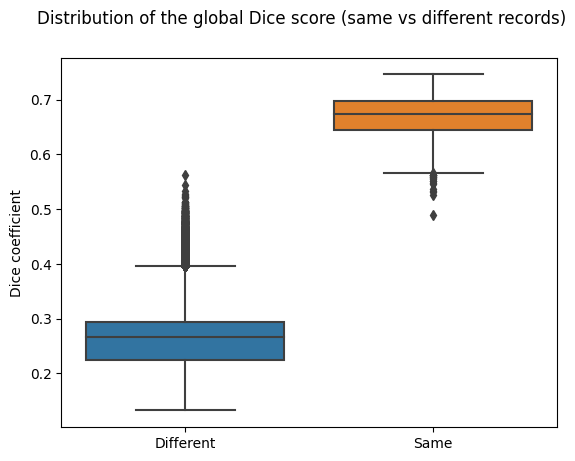

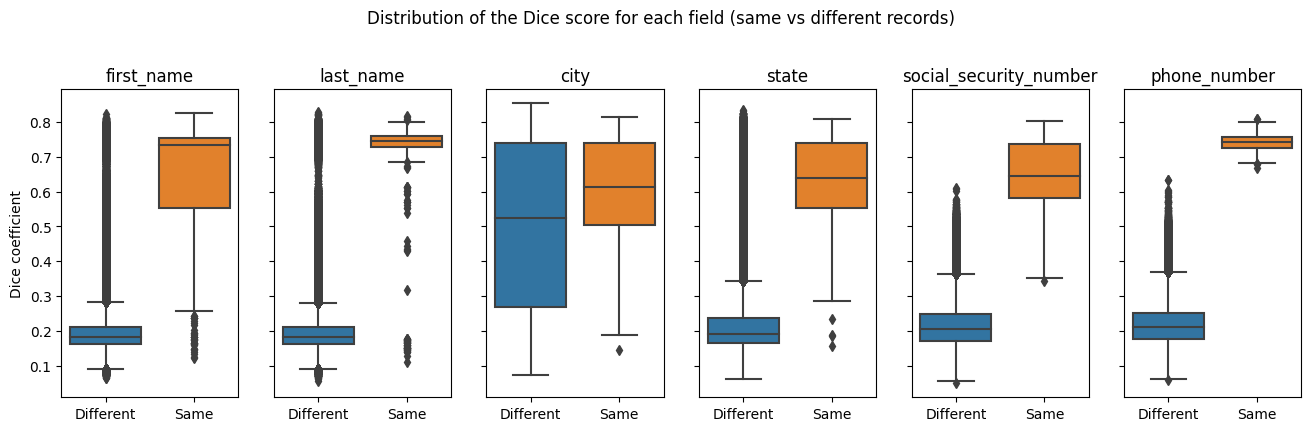

In [78]:
# Global Dice score distribution

sns.boxplot(x="same", y="dice", data=dices)
plt.suptitle("Distribution of the global Dice score (same vs different records)")
plt.xticks([False, True], labels=["Different", "Same"])
plt.xlabel("")
plt.ylabel("Dice coefficient")
plt.show()

# Dice score distribution for each field

fig, axs = plt.subplots(1, len(ALL_FIELDS), sharex=True, sharey=True, figsize=(16, 4))
for ax, field in zip(axs, ALL_FIELDS):
    sns.boxplot(x="same", y=f"dice_{field}", data=dices, ax=ax)
    ax.set_title(field)
    ax.set_ylabel("")
    ax.set_xticklabels(["Different", "Same"])
    ax.set_xlabel("")
axs[0].set_ylabel("Dice coefficient")
fig.suptitle(f"Distribution of the Dice score for each field (same vs different records)", y=1.08)
plt.show()

In [82]:
# Import precision and recall
from sklearn.metrics import precision_score, recall_score

# Protocol 1: global Dice score > 0.6
dices["protocol1"] = dices.dice > 0.6

# Protocol 2: all but 1 field with Dice score > 0.4
dices["protocol2"] = (np.array([
    [dices[f"dice_{field}"] > 0.4 for field in ALL_FIELDS]
]).sum(axis=1) >= len(ALL_FIELDS) - 1)[0]


# Protocol 3: all but 2 fields with Dice score > 0.55
dices["protocol3"] = (np.array([
    [dices[f"dice_{field}"] > 0.55 for field in ALL_FIELDS]
]).sum(axis=1) >= len(ALL_FIELDS) - 2)[0]

# Protocol 4: social security number or phone number with Dice score > 0.65
dices["protocol4"] = (dices.dice_social_security_number > 0.7) | (dices.dice_phone_number > 0.65)


# Comparison of the protocols

comparison = pd.DataFrame.from_records([
    {
        "Protocol": f"Protocol {i}",
        "Precision": precision_score(dices.same, dices[f"protocol{i}"]),
        "Recall": recall_score(dices.same, dices[f"protocol{i}"]),
    } for i in range(1, 5)
], index="Protocol".split())
comparison


,Precision,Recall
Protocol,,
Protocol 1,1.000000,0.944196
Protocol 2,1.000000,0.983631
Protocol 3,0.999227,0.962054
Protocol 4,1.000000,1.000000
